In [1]:
pip install transformers torch scikit-learn nltk


Note: you may need to restart the kernel to use updated packages.


# Logs Preprocessing


In [1]:
import os
import glob
import nltk
from nltk.tokenize import word_tokenize
import re

'''
Function: read_logs
Objective: This function reads log entries from log files in the current directory
Input: file_list (optional). List of log files to read. 
    If None, all log files in the current directory will be read.
Output: log_entries. List of log entries read from the log files.
'''
def read_logs(file_list=None):
    log_entries = []
    directory = os.getcwd()  # Get the current working directory
    if file_list is None:
        file_paths = glob.glob(os.path.join(directory, "*.jrn"))
    else:
        file_paths = [os.path.join(directory, file) for file in file_list]
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            log_entries.extend(lines)
    return log_entries

'''
    Function: preprocess_logs
    Objective: This function preprocesses log entries by removing timestamps, operation codes, special characters, and numbers.
                It also tokenizes the log entries into words and filters out non-readable words.
    Input: log_entries. List of log entries to preprocess.
    Output: processed_logs. List of preprocessed log entries.
'''
def preprocess_logs(log_entries):
    processed_logs = []
    for entry in log_entries:
        # Simplify whitespace and strip newlines
        entry = entry.strip().replace("\n", "")
        # Remove leading timestamps and operation codes
        entry = re.sub(r"^\s*\d{2}:\d{2}:\d{2}\s+\d+\s+", "", entry)
        # Remove special formatting characters and digits clustered as error codes or IDs
        entry = re.sub(r"\d{2,}", "", entry)  # removes long sequences of digits
        entry = re.sub(r"[<>{}()\[\]]", "", entry)  # removes special characters
        # Remove sequences of backslashes and alphanumeric characters
        entry = re.sub(r'\\[0-9A-Za-z]+', '', entry)
        # Tokenize the entry into words
        words = word_tokenize(entry)
        # Filter out non-readable words (e.g., punctuation, numbers)
        readable_words = [word for word in words if word.isalpha() and len(word) > 4]
        if len(readable_words) > 0:
            # Reconstruct the entry from readable words
            processed_entry = " ".join(readable_words)
            processed_logs.append(processed_entry)
    return processed_logs



nltk.download('punkt')
log_entries = read_logs()
# Read and preprocess log entries
log_entries = read_logs()
processed_entries = preprocess_logs(log_entries)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# This section is about converting text data to numerical format using TF-IDF and splitting the data into training and testing sets.


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Convert processed log entries to numerical format using TF-IDF. This is sort of normalization
# for text data. TF-IDF Vectorizer using 4-grams
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(4, 4))
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_entries)

# Split the data
train_data, test_data = train_test_split(tfidf_matrix, test_size=0.2, random_state=42)
train_data = train_data.toarray()
test_data = test_data.toarray()



# Autoencoder Architecture 


Each layer reduces the dimensionality, allowing the model to learn a compressed representation of the data.

The sigmoid activation function is  used in the output layer of an autoencoder when the goal is to reconstruct data scaled between 0 and 1.  The sigmoid function outputs values between 0 and 1, which matches the range of the TF-IDF features used in the conversion oif text data to numerical data. Also, it introduces non-linearity, enabling the model to capture complex patterns

In an autoencoder, the latent space is the layer in the middle of the network that represents the compressed knowledge of the input data. It is the output of the encoder part of the network and serves as the input to the decoder part.  It could be seen as a sort of **embeddings**

Epoch 1/10
12096/12096 ━━━━━━━━━━━━━━━━━━━━ 158s 13ms/step - loss: 0.0026 - val_loss: 4.1685e-04
Epoch 2/10
12096/12096 ━━━━━━━━━━━━━━━━━━━━ 133s 11ms/step - loss: 4.1669e-04 - val_loss: 4.1685e-04
Epoch 3/10
12096/12096 ━━━━━━━━━━━━━━━━━━━━ 127s 10ms/step - loss: 4.1658e-04 - val_loss: 4.1685e-04
Epoch 4/10
12096/12096 ━━━━━━━━━━━━━━━━━━━━ 125s 10ms/step - loss: 4.1627e-04 - val_loss: 4.1685e-04
Epoch 5/10
12096/12096 ━━━━━━━━━━━━━━━━━━━━ 130s 11ms/step - loss: 4.1590e-04 - val_loss: 4.1685e-04
Epoch 6/10
12096/12096 ━━━━━━━━━━━━━━━━━━━━ 128s 11ms/step - loss: 4.1641e-04 - val_loss: 4.1685e-04


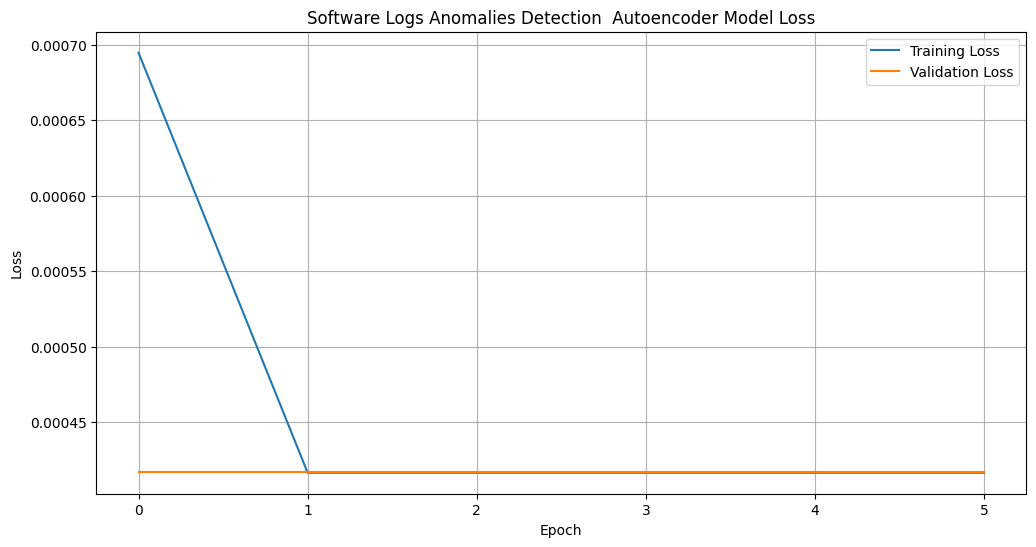

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


# Define the autoencoder architecture
input_dim = train_data.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(512, activation='relu')(input_layer)
encoder = Dense(256, activation='relu')(encoder)
latent_space = Dense(128, activation='relu', name='latent_space')(encoder)  
decoder = Dense(256, activation='relu')(latent_space)
decoder = Dense(512, activation='relu')(decoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = autoencoder.fit(
    train_data, 
    train_data, 
    epochs=10, 
    batch_size=64, 
    shuffle=True, 
    validation_split=0.1, 
    callbacks=[early_stopping],
    verbose=1
)

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Software Logs Anomalies Detection  Autoencoder Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


Model Convergence: The model converges quickly, as indicated by the rapid decrease in training loss.
Generalization: The close and stable validation loss suggests good generalization without overfitting.
Possible Early Stopping: You might not need many epochs for training since the loss stabilizes early.

# Detect Anomalies in Train Data
Use the reconstruction error to identify anomalies:

26880/26880 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step


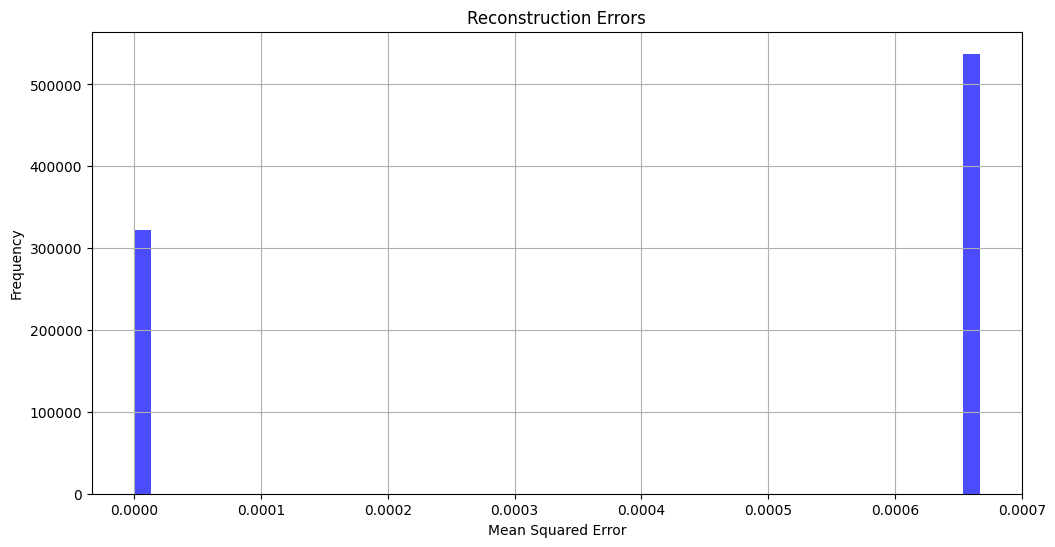

In [4]:
import numpy as np
reconstructed_data = autoencoder.predict(train_data)
reconstruction_errors = np.mean(np.square(train_data - reconstructed_data), axis=1)
# Histogram of reconstruction_errors
plt.figure(figsize=(12, 6))
plt.hist(reconstruction_errors, bins=50, color='blue', alpha=0.7)
plt.title('Reconstruction Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [15]:
threshold = np.percentile(reconstruction_errors, 95)
threshold
anomalies = np.where(reconstruction_errors > threshold)[0]

print("Threshold:", threshold)
print("Anomalous log entries:")
for idx in anomalies:
    print(idx, log_entries[idx])


Threshold: 0.0006666666666666666
Anomalous log entries:
41 

88  15:04:07  5010 <Error Mgr> Device state (optional ) TEXT_TO_SPEECH                    is: OPERATIONAL (1) 

89  15:04:07  5010 <Error Mgr> Device state (optional ) TRANSACTIONFW                     is: OPERATIONAL (1) 

92  15:04:07  5010 <Error Mgr> Device state (optional ) VOICE_SUPPORT                     is: OPERATIONAL (1) 

95  15:04:07  5010 <Error Mgr> Device state (optional ) WN_NOTE_ID_LIST                   is: OPERATIONAL (1) 

166                               operational    : CARD_READER EPP SAFE_DOOR

174                                 USD  2000 18852 18852    0 O

175                                 USD  2000 18781 18781    0 O

210                                 USD   100 14185 14185    0 O

257  13:02:31  5010 <Error Mgr> Device state (mandatory) COMMUNICATION_1                   is: NOT_OPERATIONAL (2) 

260  13:02:31  5010 <Error Mgr> Device state (optional ) DDC_CASHIN                        is: OPE

# Visualization of Latent Space        

In [5]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract embeddings from the latent space
latent_space_model = Model(inputs=autoencoder.input, outputs=latent_space)
latent_space_embeddings = latent_space_model.predict(train_data)

#t-SNE in 3D
tsne = TSNE(n_components=3, random_state=42)
tsne_embeddings_3d = tsne.fit_transform(latent_space_embeddings)

# Plot t-SNE embeddings in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot normal data points
ax.scatter(tsne_embeddings_3d[~anomalies, 0], tsne_embeddings_3d[~anomalies, 1], tsne_embeddings_3d[~anomalies, 2], 
           c='b', label='Normal', alpha=0.5)

# Plot anomalous data points
ax.scatter(tsne_embeddings_3d[anomalies, 0], tsne_embeddings_3d[anomalies, 1], tsne_embeddings_3d[anomalies, 2], 
           c='r', label='Anomaly', alpha=0.5)

ax.set_title('3D t-SNE Visualization of Latent Space Embeddings')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.legend()
plt.show()


26880/26880 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\ASAI\log_analytics\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\HP\OneDrive\Documents\Eduardo Toledo\ASAI\log_analytics\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


# Inference in test data

In [ ]:
# Extract embeddings from the latent space
latent_space_model = Model(inputs=autoencoder.input, outputs=latent_space)
latent_space_embeddings = latent_space_model.predict(test_data)

#t-SNE in 3D
tsne = TSNE(n_components=3, random_state=42)
tsne_embeddings_3d = tsne.fit_transform(latent_space_embeddings)

# Plot t-SNE embeddings in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot normal data points
ax.scatter(tsne_embeddings_3d[~anomalies, 0], tsne_embeddings_3d[~anomalies, 1], tsne_embeddings_3d[~anomalies, 2], 
           c='b', label='Normal', alpha=0.5)

# Plot anomalous data points
ax.scatter(tsne_embeddings_3d[anomalies, 0], tsne_embeddings_3d[anomalies, 1], tsne_embeddings_3d[anomalies, 2], 
           c='r', label='Anomaly', alpha=0.5)

ax.set_title('3D t-SNE Visualization of Latent Space Embeddings')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.legend()
plt.show()

# FASTAPI to create and inference endpoint



## Serialize Custom Tokenizer  to be used in production


In [ ]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import pickle

class CustomTokenizer:
    def __init__(self, vectorizer):
        nltk.download('punkt')
        self.vectorizer = vectorizer

    def __preprocess(self, log_entries):
        processed_logs = []
        for entry in log_entries:
            entry = entry.strip().replace("\n", "")
            entry = re.sub(r"^\s*\d{2}:\d{2}:\d{2}\s+\d+\s+", "", entry)
            entry = re.sub(r"\d{2,}", "", entry)
            entry = re.sub(r"[<>{}()\[\]]", "", entry)
            entry = re.sub(r'\\[0-9A-Za-z]+', '', entry)
            words = word_tokenize(entry)
            readable_words = [word for word in words if word.isalpha() and len(word) > 4]
            if len(readable_words) > 0:
                processed_entry = " ".join(readable_words)
                processed_logs.append(processed_entry)
        return processed_logs

    def fit(self, log_entries):
        processed_entries = self.__preprocess(log_entries)
        self.vectorizer.fit(processed_entries)
        
    def transform(self, log_entries):
        processed_entries = self.__preprocess(log_entries)
        return self.vectorizer.transform(processed_entries)
    
    def fit_transform(self, log_entries):
        processed_entries = self.__preprocess(log_entries)
        return self.vectorizer.fit_transform(processed_entries)
    
# Create a TF-IDF vectorizer and custom tokenizer
log_entries = read_logs()
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(4, 4))
custom_tokenizer = CustomTokenizer(vectorizer)

# Transform log entries
log_data_transformed = custom_tokenizer.fit_transform(log_entries).toarray()


# Serialize autoencoder model to be used in production

In [ ]:
autoencoder.save('autoencoder_model.h5')

# Inference endpoint with FastApi

In [ ]:
from fastapi import FastAPI
from tensorflow.keras.models import load_model
import pickle
import numpy as np


app = FastAPI()

threshold = 0.0005
# Load the autoencoder model
autoencoder = load_model('autoencoder_model.h5')

# Load the custom tokenizer
with open('custom_tokenizer.pkl', 'rb') as file:
    custom_tokenizer = pickle.load(file)

@app.post("/predict/")
async def predict(log_entry: str):
    # Preprocess the log entry and convert it to a numerical format
    log_entry_vectorized = custom_tokenizer.transform([log_entry]).toarray()
    
    # Make a prediction using the autoencoder model
    reconstructed_data = autoencoder.predict(log_entry_vectorized)
    reconstruction_error = np.mean(np.square(log_entry_vectorized - reconstructed_data))
    
    # Determine if the log entry is an anomaly based on the reconstruction error
    is_anomaly = reconstruction_error > threshold
    
    return {"reconstruction_error": reconstruction_error, "is_anomaly": is_anomaly}
